In [1]:
# load arrs, pgv2/3/4
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
import numpy as np

np.set_printoptions(threshold=1000, linewidth=200)
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import os
import functools

def load_data(str_):
    path_ = os.path.dirname(os.getcwd()) + '/sc_project/test_data/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

def freeze_array(BA, P):
    P2 = np.zeros_like(P)
    P2[:, 0] = P[:, 0]
    for t in range(1, P.shape[1]):
        if BA[t] == 0:
            P2[:, t] = P[:, t]  # Update to current value in P
        else:
            P2[:, t] = P2[:, t - 1]  # Hold previous value
    return P2

def compare_arrays(pos_arr, pos_plan_arr):
    return np.where(pos_arr == pos_plan_arr, 0, 1)


file_ = 'outer_loop_pg_new_v4_26_09-022146.pkl' # 'outer_loop_pg_new_v4_24_09-201550.pkl' # 'outer_loop_pg_new_v4_18_09-093520.pkl' # 'outer_loop_pg_new_v3_c__18_09-092611.pkl' # 'outer_loop_pg_new_v4_ppo_new__19_09-172733.pkl' # 'outer_loop_pg_new_v3_c__18_09-092611.pkl' # 'sc_project/test_data/outer_loop_pg_new_v4_ppo_new__19_09-172733.pkl' # 'outer_loop_pg_new_v4_17_09-200259.pkl' # 'outer_loop_pg_new_v3_c__18_09-092611.pkl' # 'outer_loop_pg_new_v3_c__15_09-203653.pkl'
# (other,weights_s) = load_data(file_) # # [VMAPS,STEPS,N]x2,[VMAPS,STEPS,2]x3,[VMAPS,STEPS]x2
other = load_data(file_)
(r_arr,rt_arr,sample_arr,pos_plan_arr,pos_arr,dot_arr) = other # (r_arr,rt_arr,sample_arr,pos_plan_arr,pos_arr,dot_arr) (r_arr,rt_arr,pos_arr,dot_arr)
# sample_arr = compare_arrays(pos_arr, pos_plan_arr)
print('r_arr.shape=',r_arr.shape,'rt_arr.shape=',rt_arr.shape,'pos_plan_arr.shape=',pos_plan_arr.shape,'pos_arr.shape=',pos_arr.shape,'dot_arr.shape=',dot_arr.shape,'sample_arr.shape=',sample_arr.shape)
# pos_plan_arr, pos_arr, dot_arr = pos_plan_arr[:,1:,:], pos_arr[:,1:,:], dot_arr[:,1:,:]

r_arr.shape= (1000, 120) rt_arr.shape= (1000, 120) pos_plan_arr.shape= (1000, 121, 2) pos_arr.shape= (1000, 121, 2) dot_arr.shape= (1000, 121, 2) sample_arr.shape= (1000, 120)


In [2]:
# sort arrs, pgv1/2/3/4
tot_reward = jnp.sum(r_arr, axis=1)
r_tot_desc = jnp.argsort(tot_reward)[::-1]
r_tot_asc = jnp.argsort(tot_reward) #[::-1]
tot_plan = jnp.sum(sample_arr, axis=1)
plan_desc = jnp.argsort(tot_plan)[::-1]
# tot_loss_v = jnp.sum(loss_v_arr_, axis=1)
# loss_v_asc = jnp.argsort(tot_loss_v) #[::-1]
# loss_v_desc = jnp.argsort(tot_loss_v)[::-1]
# tot_loss_d = jnp.sum(loss_d_arr_, axis=1)
# loss_d_asc = jnp.argsort(tot_loss_d) #[::-1]
print('r_tot_desc=',r_tot_desc[:10])
print('r_tot_asc=',r_tot_asc[:10])
print('plan_desc=',plan_desc[:10])
# print('loss_v_asc=',loss_v_asc[:10])
# print('loss_v_desc=',loss_v_desc[:10])
# print('loss_d_asc=',loss_d_asc[:10])

r_tot_desc= [815 106 449 434 862 740 743 291 691 884]
r_tot_asc= [812 617 338 584 657  72 247 853 952 566]
plan_desc= [760 982 273 103 738 734 529 316 287 898]


sample_arr.shape= (1000, 120)
pos_arr.shape= (1000, 121, 2)
pos_plan_arr.shape= (1000, 121, 2)


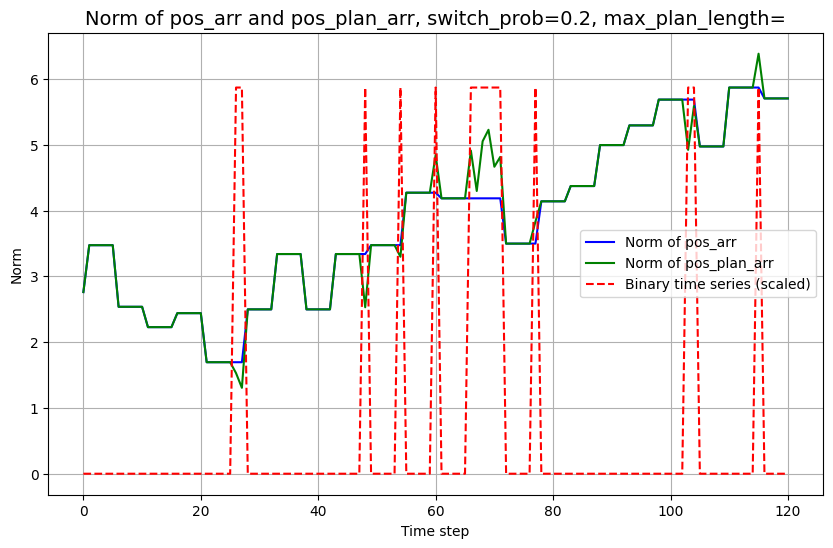

In [3]:
# v2/3, norm of pos_arr and pos_plan_arr:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# plot timeseries, v3
print('sample_arr.shape=',sample_arr.shape)
print('pos_arr.shape=',pos_arr.shape)
print('pos_plan_arr.shape=',pos_plan_arr.shape)

k = 0
binary_array = sample_arr[k,:] # .T, -1
binary_array = jnp.concatenate([jnp.zeros((1,)),binary_array],axis=0)

# Calculate the norms
norm_pos_arr = jnp.linalg.norm(pos_arr[k,:,:], axis=1) # .T
norm_pos_plan_arr = jnp.linalg.norm(pos_plan_arr[k,:,:], axis=1) # .T

# Create the plot
plt.figure(figsize=(10, 6))

# Plotting norms
plt.plot(norm_pos_arr, label="Norm of pos_arr", color='blue')
plt.plot(norm_pos_plan_arr, label="Norm of pos_plan_arr", color='green')

# Plotting binary time series
plt.plot(binary_array * norm_pos_arr.max(), label="Binary time series (scaled)", color='red', linestyle='--')

# Additional plot settings
plt.title(f"Norm of pos_arr and pos_plan_arr, switch_prob={'0.2'}, max_plan_length={''}", fontsize=14)
plt.xlabel("Time step")
plt.ylabel("Norm")
plt.legend()
plt.grid(True)

plt.show()

/Users/lukej/Documents/meta_rl_ego_sim/venv3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3634: RuntimeWarning: divide by zero encountered in negative
  if np.any(np.less(err, -err, out=res, where=(err == err))):
/Users/lukej/Documents/meta_rl_ego_sim/venv3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3634: RuntimeWarning: divide by zero encountered in equal
  if np.any(np.less(err, -err, out=res, where=(err == err))):
/Users/lukej/Documents/meta_rl_ego_sim/venv3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3634: RuntimeWarning: divide by zero encountered in less
  if np.any(np.less(err, -err, out=res, where=(err == err))):
/Users/lukej/Documents/meta_rl_ego_sim/venv3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3642: RuntimeWarning: divide by zero encountered in multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
/Users/lukej/Documents/meta_rl_ego_sim/venv3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3642: RuntimeWarnin

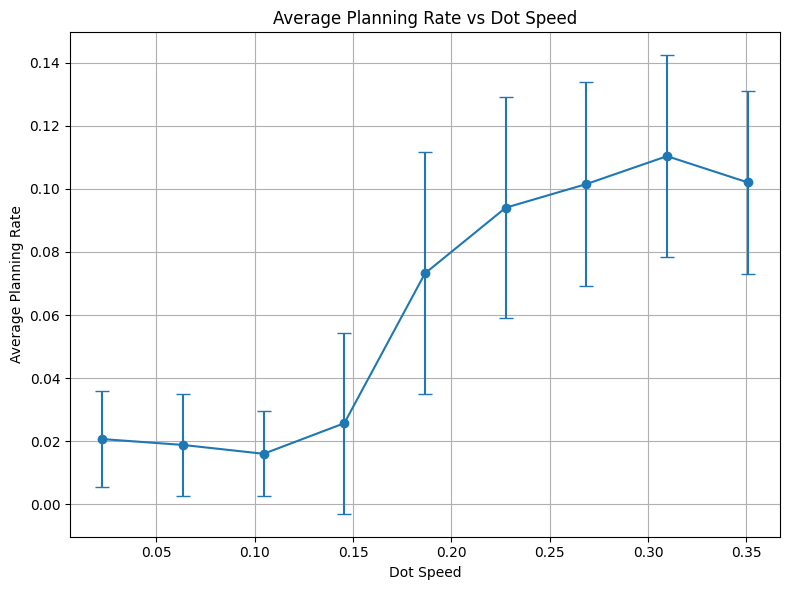

In [4]:
# avg planning rate vs dot speed

%matplotlib inline

dot_positions = dot_arr[:,:,:]
decisions = sample_arr[:,:]

# Assume dot_positions has shape [1000, 121, 2]
# Assume decisions has shape [1000, 120]

# Calculate dot speeds
dot_diffs = np.diff(dot_positions, axis=1)  # Shape: [1000, 120, 2]
dot_speeds = np.linalg.norm(dot_diffs, axis=2)  # Shape: [1000, 120]
mean_dot_speeds = np.mean(dot_speeds, axis=1)  # Shape: [1000]

# Calculate planning rates
planning_rates = np.mean(decisions, axis=1)  # Shape: [1000]

# Define speed bins
speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=10)
speed_bin_centers = (speed_bins[:-1] + speed_bins[1:]) / 2

# For each speed bin, calculate mean and std of planning rates
mean_rates = []
std_rates = []

for i in range(len(speed_bins) - 1):
    mask = (mean_dot_speeds >= speed_bins[i]) & (mean_dot_speeds < speed_bins[i + 1])
    rates_in_bin = planning_rates[mask]
    mean_rates.append(np.mean(rates_in_bin))
    std_rates.append(np.std(rates_in_bin))

# Plotting
plt.figure(figsize=(8, 6))
plt.errorbar(speed_bin_centers, mean_rates, yerr=std_rates, fmt='o-', capsize=5)
plt.xlabel('Dot Speed')
plt.ylabel('Average Planning Rate')
plt.title('Average Planning Rate vs Dot Speed')
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# full ani pgv2/3 wip
%matplotlib qt
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
import functools
from matplotlib.patches import Ellipse

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def gen_vectors(m, A): # modules/neurons, aperture
    x = np.linspace(-(A-A/m), (A-A/m), m)
    x_ = np.tile(x, (m, ))
    y_ = np.repeat(np.flip(x), m)
    return np.vstack([x_, y_])

def circ_mean_var(v_pred,vec_range):
    v_clamped = np.clip(v_pred,0,None)
    # get x/y coords
    x_y_coords = gen_vectors(np.int32(np.sqrt(len(v_clamped))),vec_range)
    x = x_y_coords[0,:]
    y = x_y_coords[1,:]
    # weighted complex numbers
    z_x = v_pred*(np.cos(x) + 1j*np.sin(x))
    z_y = v_pred*(np.cos(y) + 1j*np.sin(y))
    # mean
    mean_x = np.angle(np.sum(z_x)/np.sum(v_clamped))
    mean_y = np.angle(np.sum(z_y)/np.sum(v_clamped))
    # weighted circular variance for each angle
    circular_var_x = 1 - np.abs(np.sum(z_x) / np.sum(v_clamped))
    circular_var_y = 1 - np.abs(np.sum(z_y) / np.sum(v_clamped))
    circular_cov_matrix = np.diag([circular_var_x, circular_var_y])
    eigvals,eigvecs = np.linalg.eigh(circular_cov_matrix)
    sigma_x,sigma_y = np.sqrt(eigvals)  # no Scale factor for visualization
    return x_y_coords,x,y,mean_x,mean_y,sigma_x,sigma_y

def set_axis_properties(ax,lim,labels,title=''):
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_aspect('equal', 'box')  
    ax.set_title(title)
    ticks = np.linspace(-lim,lim,5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

def get_aperture_points(agent_t,aperture,density):
    x_horizontal = np.linspace(agent_t[0] - aperture, agent_t[0] + aperture, density)
    y_top = np.full(density, agent_t[1] + aperture)
    y_bottom = np.full(density, agent_t[1] - aperture)
    y_vertical = np.linspace(agent_t[1] - aperture, agent_t[1] + aperture, density)
    x_left = np.full(density, agent_t[0] - aperture)
    x_right = np.full(density, agent_t[0] + aperture)
    x_tot = np.concatenate([x_left, x_right, x_horizontal, x_horizontal])
    y_tot = np.concatenate([y_vertical, y_vertical, y_bottom, y_top])
    return x_tot,y_tot

def is_point_in_ellipse(x,y,h,k,a,b):
    ellipse_eq = ((x - h)**2)/(a ** 2) + ((y - k)**2)/(b**2)
    return ellipse_eq <= 1

def vonmises_fit(x_coords,y_coords,v_pred_vec):
    # v_pred_vec = np.clip(v_pred_vec,0,None)
    # v_pred_norm = v_pred_vec/np.sum(v_pred_vec)
    scalar = 100
    kappa_max = 2
    integer_weights = np.int32(np.round(v_pred_vec*scalar))
    x_samples = np.repeat(x_coords, integer_weights)
    y_samples = np.repeat(y_coords, integer_weights)
    kappa_x,loc_x,_ = scipy.stats.vonmises.fit(x_samples)
    kappa_y,loc_y,_ = scipy.stats.vonmises.fit(y_samples)
    kappa_x = np.min([kappa_x,kappa_max])
    kappa_y = np.min([kappa_y,kappa_max])
    # mean_magnitude = (np.exp(kappa_x+kappa_y)/((2*np.pi)**2 * scipy.special.i0(kappa_x) * scipy.special.i0(kappa_y)))
    log_numerator = kappa_x + kappa_y
    log_denominator = 2 * np.log(2*np.pi) + np.log(scipy.special.i0(kappa_x)) + np.log(scipy.special.i0(kappa_y))
    log_result = log_numerator - log_denominator
    mean_magnitude = np.exp(log_result)
    return kappa_x,loc_x,kappa_y,loc_y,mean_magnitude

def animate(i,r_arr,dot_arr,pos_plan_arr,pos_arr,dot,agent_plan,agent,aperture_points_plan,aperture_points,act_space_points_plan,act_space_points,L):
    dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
    agent_plan.set_data(mod_(pos_plan_arr[i, 0]), mod_(pos_plan_arr[i, 1]))
    agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))
    # dot_hat.set_data(mod_(dot_hat_arr[i, 0]), mod_(dot_hat_arr[i, 1]))

    if i == 0:
        aperture_points.set_color('green')
        # L.get_texts()[0].set_text(f'Frame={i}, Reward=')
    else:
        aperture_points.set_color('black')

    # x_y_coords,x,y,mean_x,mean_y,sigma_x,sigma_y = circ_mean_var(v_pred_arr[i],np.pi)### think
    # # x_y_coords,x,y,mean_x_ap,mean_y_ap,sigma_x_ap,sigma_y_ap = circ_mean_var(v_pred_arr[i],np.pi)### think
    # ell_circular.set_center((mod_(mean_x+pos_plan_arr[i, 0]), mod_(mean_y+pos_plan_arr[i, 1])))
    # ell_circular.width = SIGMA_SCALE*sigma_x
    # ell_circular.height = SIGMA_SCALE*sigma_y
    # ell_circular_v_pred.set_center((mean_x, mean_y))
    # ell_circular_v_pred.width = SIGMA_SCALE*sigma_x
    # ell_circular_v_pred.height = SIGMA_SCALE*sigma_y
    # ell_circular_v_t.set_center((mean_x, mean_y))
    # ell_circular_v_t.width = SIGMA_SCALE*sigma_x
    # ell_circular_v_t.height = SIGMA_SCALE*sigma_y
    # if i>0:
    #     in_ell_array[i] = is_point_in_ellipse(mod_(mean_x+pos_plan_arr[i, 0]), mod_(mean_y+pos_plan_arr[i, 1]), mod_(dot_arr[i,0]), mod_(dot_arr[i,1]), SIGMA_SCALE*sigma_x, SIGMA_SCALE*sigma_y)
    #     kappa_x,loc_x,kappa_y,loc_y,mean_magnitude = vonmises_fit(x_y_coords[0,:],x_y_coords[1,:],v_pred_arr[i])
    lab = f'Frame={i}, Reward={r_arr[i]:.3f}' #, k={kappa_x:.3f},{kappa_y:.3f}'
    L.get_texts()[0].set_text(lab)

    # scatters_pred.set_offsets(neuron_locs.T)
    # scatters_pred.set_array(v_pred_arr[i])
    # scatters_pred.set_sizes(15 * np.sqrt(v_pred_arr[i])) # []
    # scatters_pred.set_facecolors('k')

    # scatters_t.set_offsets(neuron_locs.T)
    # scatters_t.set_array(v_t_arr[i])
    # scatters_t.set_sizes(15 * np.sqrt(v_t_arr[i])) # []
    # scatters_t.set_facecolors('k')
    x_aperture_plan,y_aperture_plan = get_aperture_points(pos_plan_arr[i],APERTURE,DENSITY_DEFAULT)
    aperture_points_plan.set_offsets(np.c_[mod_(x_aperture_plan), mod_(y_aperture_plan)])
    x_aperture,y_aperture = get_aperture_points(pos_arr[i],APERTURE,DENSITY_DEFAULT)
    aperture_points.set_offsets(np.c_[mod_(x_aperture), mod_(y_aperture)])
    # x_aperture_centre,y_aperture_centre = get_aperture_points(np.array([0,0]),APERTURE,DENSITY_DEFAULT)
    # aperture_points_v_pred.set_offsets(np.c_[mod_(x_aperture_centre), mod_(y_aperture_centre)])
    # aperture_points_v_t.set_offsets(np.c_[mod_(x_aperture_centre), mod_(y_aperture_centre)])
    x_act_space_plan,y_act_space_plan = get_aperture_points(pos_plan_arr[i],ACTION_SPACE,DENSITY_ACT_PLAN)
    act_space_points_plan.set_offsets(np.c_[mod_(x_act_space_plan), mod_(y_act_space_plan)])
    x_act_space,y_act_space = get_aperture_points(pos_arr[i],ACTION_SPACE,DENSITY_ACT_PLAN)
    act_space_points.set_offsets(np.c_[mod_(x_act_space), mod_(y_act_space)])

    # x_plan_space,y_plan_space = get_aperture_points(pos_arr[i],PLAN_SPACE,DENSITY_PLAN_SPACE)
    # plan_space_points.set_offsets(np.c_[mod_(x_plan_space), mod_(y_plan_space)])
    
    return [dot,agent_plan,agent,aperture_points_plan,aperture_points,act_space_points_plan,act_space_points,L]

k = 273 # 103 # 273 # 743 # 959 # 0,202, 275
interval = 150
APERTURE = (1/2)*np.pi # (3/5)*np.pi # (1/2)*np.pi # (np.sqrt(2)/2)*np.pi # np.pi/2
ACTION_FRAC = 1/2
ACTION_SPACE = ACTION_FRAC*APERTURE # np.pi/4
PLAN_FRAC_REL = 2 #3/2 # 3/2
PLAN_SPACE = PLAN_FRAC_REL*ACTION_SPACE # np.pi/2
STEPS = pos_arr.shape[1]
MODULES = 7 # 7 # 9 # 17 # 15
# NEURONS_DISP = np.int32(np.sqrt(v_pred_arr.shape[2])) ##14 # 16 # 15 # 15 # 12 # 6 # ''full'' np.int32(NEURONS_AP*(np.pi//APERTURE))
SIGMA_SCALE = 3

DENSITY_DEFAULT = 1000
DENSITY_ACT_PLAN = 15 # 10

# neuron_locs = gen_vectors(NEURONS_DISP,jnp.pi) # NEURONS
# v_pred_arr_ = np.clip(v_pred_arr[k,:,:],0,1)
# v_t_arr_ = v_t_arr[k,:,:]
r_arr_ = r_arr[k,:]
dot_arr_ = dot_arr[k,:,:] # [STEPS,2]
pos_plan_arr_ = pos_plan_arr[k,:,:] # [STEPS,2]
pos_arr_ = pos_arr[k,:,:] # [STEPS,2]
# rel_vec_hat_arr_ = rel_vec_hat_arr[k,:,:] # [STEPS,2]
# dot_hat_arr_ = mod_(rel_vec_hat_arr_ + pos_arr_)

fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax_ani = plt.subplot(gs[0:2, 0:2],aspect='equal')
set_axis_properties(ax_ani,jnp.pi,["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
agent_plan, = ax_ani.plot(mod_(pos_plan_arr_[0, 0]), mod_(pos_plan_arr_[0, 1]), color='lightgrey', marker='+', markersize=12) #, label='agent')
agent, = ax_ani.plot(mod_(pos_arr_[0, 0]), mod_(pos_arr_[0, 1]), 'k+', markersize=12) #, label='agent')
dot, = ax_ani.plot(mod_(dot_arr_[0, 0]), mod_(dot_arr_[0, 1]), 'rx', markersize=10) #, label='dot')
text_ani, = ax_ani.plot([], [], '', label=f'Frame=0, Reward=')
# dot_hat, = ax_ani.plot(mod_(dot_hat_arr_[0, 0]), mod_(dot_hat_arr_[0, 1]), 'bx', markersize=10, label='dot_hat')

aperture_points = ax_ani.scatter([], [], color='black', s=1)
aperture_points_plan = ax_ani.scatter([], [], color='lightgrey', s=1)
act_space_points = ax_ani.scatter([], [], color='black', s=1)
act_space_points_plan = ax_ani.scatter([], [], color='lightgrey', s=1)
# plan_space_points = ax_ani.scatter([], [], color='lightgrey', s=1)

# ell_circular = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
# ell_circular_patch = ax_ani.add_patch(ell_circular)
# text_ani = ax_ani.text(0.5, 0.8, '', transform=ax_ani.transAxes)
# ax_ani.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax_ani.legend(loc='upper right')
L=ax_ani.legend(loc='upper right')

# in_ell_array = np.zeros(STEPS,)

# ax_pred = plt.subplot(gs[2, 0], aspect='equal')
# # update scatter
# scatters_pred = ax_pred.scatter(
#     neuron_locs[0, :], neuron_locs[1, :], 
#     c='k', # v_pred_arr_[0], 
#     s=15 * np.sqrt(v_pred_arr_[0]), 
#     marker='o',
#     vmin=0, vmax=1)
# aperture_points_v_pred = ax_pred.scatter([], [], color='black', s=0.5)
# ell_circular_v_pred = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
# ecp_v_pred = ax_pred.add_patch(ell_circular_v_pred)
# set_axis_properties(ax_pred, jnp.pi, ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"], 'v_pred')

# ax_t = plt.subplot(gs[2, 1], aspect='equal')
# # update scatter
# scatters_t = ax_t.scatter(
#     neuron_locs[0, :], neuron_locs[1, :], 
#     c='k', # v_t_arr_[0], 
#     s=15 * np.sqrt(v_t_arr_[0]), 
#     marker='o',
#     vmin=0, vmax=1)  # Assuming activations range from 0 to 1
# aperture_points_v_t = ax_t.scatter([], [], color='black', s=0.5)
# ell_circular_v_t = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
# ecp_v_t = ax_t.add_patch(ell_circular_v_t)
# set_axis_properties(ax_t, jnp.pi, ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"], 'v_t')

partial_animate = functools.partial(
    animate,
    # v_pred_arr=v_pred_arr_, 
    # v_t_arr=v_t_arr_, 
    r_arr=r_arr_,
    dot_arr=dot_arr_, 
    # dot_hat_arr=dot_hat_arr_,
    pos_plan_arr=pos_plan_arr_,
    pos_arr=pos_arr_, 
    dot=dot, 
    # dot_hat=dot_hat,
    agent_plan=agent_plan,
    agent=agent, 
    # neuron_locs=neuron_locs, 
    # scatters_pred=scatters_pred, 
    # scatters_t=scatters_t,
    aperture_points_plan=aperture_points_plan,
    aperture_points=aperture_points,
    # aperture_points_v_pred=aperture_points_v_pred,
    # aperture_points_v_t=aperture_points_v_t,
    act_space_points_plan=act_space_points_plan,
    act_space_points=act_space_points,
    # plan_space_points=plan_space_points,
    # ell_circular=ell_circular,
    # ell_circular_v_pred=ell_circular_v_pred,
    # ell_circular_v_t=ell_circular_v_t,
    # in_ell_array=in_ell_array,
    # text_ani=text_ani,
    # ax_ani=ax_ani,
    L=L,
    )

ani = animation.FuncAnimation(
    fig=fig, 
    func=partial_animate,
    frames=STEPS, 
    blit=True, 
    interval=interval
    )

plt.tight_layout()
plt.show()

# print('in_ell_array=',in_ell_array[1:])
# print(r'% in array = ',np.sum(in_ell_array[1:])/(STEPS-1))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret =

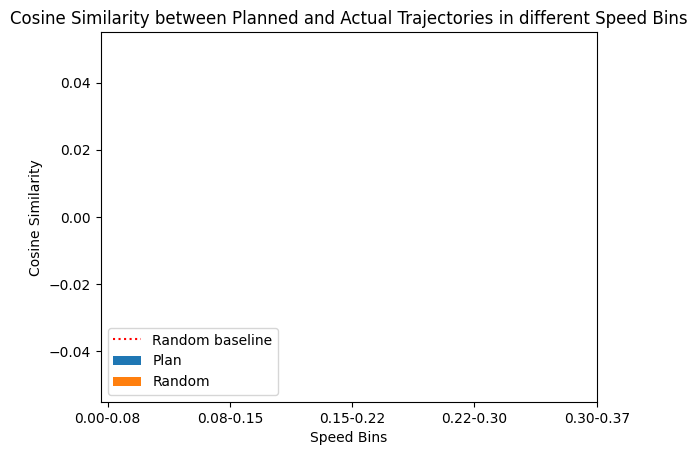

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

bins = 5
ACTION_SPACE = np.pi/2
MODULES = 9

def get_cosine_similarity(a, b):
    return 1 - scipy.spatial.distance.cosine(a, b)

x = jnp.linspace(-ACTION_SPACE,ACTION_SPACE,MODULES) ## (finer resolution)
y = jnp.linspace(-ACTION_SPACE,ACTION_SPACE,MODULES)[::-1]
xv,yv = jnp.meshgrid(x,y)
vectors = jnp.vstack([xv.flatten(),yv.flatten()])

# Calculate dot speeds
dot_diffs = np.diff(dot_arr, axis=1)
dot_speeds = np.linalg.norm(dot_diffs, axis=2)
mean_dot_speeds = np.mean(dot_speeds, axis=1)

# Define speed bins
speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=bins+1)

# Store cosine similarities
bin_cosine_similarities = []
bin_random_cosine_similarities = []

for i in range(bins):
    mask = (mean_dot_speeds >= speed_bins[i]) & (mean_dot_speeds < speed_bins[i + 1])
    masked_samples = sample_arr[mask]
    masked_pos = pos_arr[mask]
    masked_pos_plan = pos_plan_arr[mask]

    cosine_similarities = []
    random_cosine_similarities = []
    
    for trial in range(masked_pos.shape[0]):
        plan_periods = np.where(masked_samples[trial] == 1)[0]
        # print('plan_periods=',plan_periods)
        
        if not len(plan_periods):
            continue
        
        start_time = plan_periods[0]
        end_time = plan_periods[-1]  # Including the first move after the plan finishes
        
        plan_traj = masked_pos_plan[trial, end_time] - masked_pos[trial, start_time]
        # print('plan_traj=',plan_traj)
        
        # Ensure plan_traj is not a zero vector to avoid division by zero when normalizing
        if np.linalg.norm(plan_traj) == 0:
            continue
        
        plan_traj_normalized = plan_traj / np.linalg.norm(plan_traj)
        # print('plan_traj_normalized=',plan_traj_normalized)
        
        move_after_plan = masked_pos[trial, end_time + 1] - masked_pos[trial, end_time]
        
        if np.linalg.norm(move_after_plan) == 0:
            continue
        
        move_after_plan_normalized = move_after_plan / np.linalg.norm(move_after_plan)
        print('move_after_plan_normalized=',move_after_plan_normalized)
        
        cosine_similarity = get_cosine_similarity(plan_traj_normalized, move_after_plan_normalized)
        print('cosine_similarity=',cosine_similarity)

        cosine_similarities.append(cosine_similarity)
        
        # Compare with random plans
        for vector in vectors.T:
            vector_norm = vector / np.linalg.norm(vector)
            random_cosine_similarity = cosine_similarity(plan_traj_normalized, vector_norm)
            random_cosine_similarities.append(random_cosine_similarity)
    
    bin_cosine_similarities.append((np.mean(cosine_similarities), np.std(cosine_similarities)))
    bin_random_cosine_similarities.append((np.mean(random_cosine_similarities), np.std(random_cosine_similarities)))

# Plotting
x = np.arange(len(bin_cosine_similarities))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [mean for mean, std in bin_cosine_similarities], width, label='Plan', yerr=[std for mean, std in bin_cosine_similarities])
rects2 = ax.bar(x + width/2, [mean for mean, std in bin_random_cosine_similarities], width, label='Random', yerr=[std for mean, std in bin_random_cosine_similarities])

ax.axhline(y=np.mean([mean for mean, std in bin_random_cosine_similarities]), color='r', linestyle='dotted', label='Random baseline')
ax.set_xlabel('Speed Bins')
ax.set_ylabel('Cosine Similarity')
ax.set_title('Cosine Similarity between Planned and Actual Trajectories in different Speed Bins')
ax.set_xticks(x)
ax.set_xticklabels([f'{speed_bins[i]:.2f}-{speed_bins[i + 1]:.2f}' for i in range(len(speed_bins) - 1)])
ax.legend()

plt.show()


In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Sample Data
dot_positions = dot_arr #np.random.rand(1000, 121, 2)
decisions = sample_arr # np.random.randint(0, 2, (1000, 120))
pos_arr = np.random.rand(1000, 120, 2)
pos_plan_arr = np.random.rand(1000, 120, 2)
random_vectors = np.random.rand(2, 100)

# Calculate dot speeds
dot_diffs = np.diff(dot_positions, axis=1)
dot_speeds = np.linalg.norm(dot_diffs, axis=2)
mean_dot_speeds = np.mean(dot_speeds, axis=1)

# Define speed bins
speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=6)
speed_bin_centers = (speed_bins[:-1] + speed_bins[1:]) / 2

# Result containers
cos_similarities = []

# For each speed bin
for i in range(len(speed_bins) - 1):
    mask = (mean_dot_speeds >= speed_bins[i]) & (mean_dot_speeds < speed_bins[i + 1])
    
    masked_decisions = decisions[mask]
    masked_pos = pos_arr[mask]
    masked_pos_plan = pos_plan_arr[mask]
    
    similarities = []
    
    # For each trial in the bin
    for decision, pos, pos_plan in zip(masked_decisions, masked_pos, masked_pos_plan):
        # Find the planning periods
        changes = np.diff(np.concatenate([[0], decision, [0]]))
        starts = np.where(changes == 1)[0]
        ends = np.where(changes == -1)[0]
        
        for start, end in zip(starts, ends):
            plan_traj = pos_plan[end - 1] - pos[start]
            
            if np.linalg.norm(plan_traj) == 0:
                continue  # Skip if plan_traj is a zero vector, to avoid division by zero
                
            norm_plan_traj = plan_traj / np.linalg.norm(plan_traj)
            
            if end < len(decision) - 1:  # Check if there's a next timestep
                move_dir = pos[end + 1] - pos[end]
                if np.linalg.norm(move_dir) == 0:
                    continue  # Skip if move_dir is a zero vector, to avoid division by zero
                            
                norm_move_dir = move_dir / np.linalg.norm(move_dir)
                cos_sim = np.dot(norm_plan_traj, norm_move_dir)
                similarities.append(cos_sim)
                
    if similarities:  # If there are any valid similarities
        cos_similarities.append((np.mean(similarities), np.std(similarities)))
    else:
        cos_similarities.append((np.nan, np.nan))  # Or some default value, if no valid similarities exist in the bin
        
# Plot
means, stds = zip(*cos_similarities)
plt.bar(speed_bin_centers, means, yerr=stds, width=speed_bins[1] - speed_bins[0])
plt.axhline(y=0, color='r', linestyle='--')  # Replace 0 with your baseline value
plt.xlabel('Dot Speed')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Planning and Movement Direction')
plt.show()


IndexError: index 120 is out of bounds for axis 0 with size 120

In [ ]:
# v1 (no plan)

In [ ]:
# load arrs, pgv1
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
import numpy as np

np.set_printoptions(threshold=1000, linewidth=200)
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import os
import functools

def load_data(str_):
    path_ = os.path.dirname(os.getcwd()) + '/sc_project/test_data/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

def freeze_array(BA, P):
    P2 = np.zeros_like(P)
    P2[:, 0] = P[:, 0]
    for t in range(1, P.shape[1]):
        if BA[t] == 0:
            P2[:, t] = P[:, t]  # Update to current value in P
        else:
            P2[:, t] = P2[:, t - 1]  # Hold previous value
    return P2

# file_ = 'outer_loop_pg_new_v1_ppo__10_09-072009.pkl'

file_ = 'outer_loop_pg_new_v1_ppo_c_init__15_09-082206.pkl' # 'outer_loop_pg_new_v3__11_09-200631.pkl' # 'outer_loop_pg_new_v1__27_08-15_S39.pkl'
# (other,weights_s) = load_data(file_) # # [VMAPS,STEPS,N]x2,[VMAPS,STEPS,2]x3,[VMAPS,STEPS]x2
other = load_data(file_)
(r_arr,rt_arr,pos_arr,dot_arr) = other ##sample_arr (r_arr,rt_arr,pos_arr,dot_arr)
print('r_arr.shape=',r_arr.shape,'rt_arr.shape=',rt_arr.shape,'pos_plan_arr.shape=',pos_plan_arr.shape,'dot_arr.shape=',dot_arr.shape) #,'sample_arr.shape=',sample_arr.shape)
# print('weights_s["Us_f"].shape=',weights_s["Us_f"].shape)

# pos_arr = np.zeros_like(pos_plan_arr)
# for i in range(pos_plan_arr.shape[0]):
#     pos_arr[i,:,:] = freeze_array(sample_arr[i,:].T,pos_plan_arr[i,:,:]) # pm_arr[]
# print('pos_arr.shape=',pos_arr.shape)

print('pos_arr=',pos_arr[0,:,:])

In [ ]:
# sort arrs, pgv1/2/3
tot_reward = jnp.sum(r_arr, axis=1)
r_tot_desc = jnp.argsort(tot_reward)[::-1]
r_tot_asc = jnp.argsort(tot_reward) #[::-1]
# tot_loss_v = jnp.sum(loss_v_arr_, axis=1)
# loss_v_asc = jnp.argsort(tot_loss_v) #[::-1]
# loss_v_desc = jnp.argsort(tot_loss_v)[::-1]
# tot_loss_d = jnp.sum(loss_d_arr_, axis=1)
# loss_d_asc = jnp.argsort(tot_loss_d) #[::-1]
print('r_tot_desc=',r_tot_desc[:10])
print('r_tot_asc=',r_tot_asc[:10])
# print('loss_v_asc=',loss_v_asc[:10])
# print('loss_v_desc=',loss_v_desc[:10])
# print('loss_d_asc=',loss_d_asc[:10])

In [ ]:
# full ani pgv1 wip
%matplotlib qt
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
import functools
from matplotlib.patches import Ellipse

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def gen_vectors(m, A): # modules/neurons, aperture
    x = np.linspace(-(A-A/m), (A-A/m), m)
    x_ = np.tile(x, (m, ))
    y_ = np.repeat(np.flip(x), m)
    return np.vstack([x_, y_])

def circ_mean_var(v_pred,vec_range):
    v_clamped = np.clip(v_pred,0,None)
    # get x/y coords
    x_y_coords = gen_vectors(np.int32(np.sqrt(len(v_clamped))),vec_range)
    x = x_y_coords[0,:]
    y = x_y_coords[1,:]
    # weighted complex numbers
    z_x = v_pred*(np.cos(x) + 1j*np.sin(x))
    z_y = v_pred*(np.cos(y) + 1j*np.sin(y))
    # mean
    mean_x = np.angle(np.sum(z_x)/np.sum(v_clamped))
    mean_y = np.angle(np.sum(z_y)/np.sum(v_clamped))
    # weighted circular variance for each angle
    circular_var_x = 1 - np.abs(np.sum(z_x) / np.sum(v_clamped))
    circular_var_y = 1 - np.abs(np.sum(z_y) / np.sum(v_clamped))
    circular_cov_matrix = np.diag([circular_var_x, circular_var_y])
    eigvals,eigvecs = np.linalg.eigh(circular_cov_matrix)
    sigma_x,sigma_y = np.sqrt(eigvals)  # no Scale factor for visualization
    return x_y_coords,x,y,mean_x,mean_y,sigma_x,sigma_y

def set_axis_properties(ax,lim,labels,title=''):
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_aspect('equal', 'box')  
    ax.set_title(title)
    ticks = np.linspace(-lim,lim,5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

def get_aperture_points(agent_t,aperture,density):
    x_horizontal = np.linspace(agent_t[0] - aperture, agent_t[0] + aperture, density)
    y_top = np.full(density, agent_t[1] + aperture)
    y_bottom = np.full(density, agent_t[1] - aperture)
    y_vertical = np.linspace(agent_t[1] - aperture, agent_t[1] + aperture, density)
    x_left = np.full(density, agent_t[0] - aperture)
    x_right = np.full(density, agent_t[0] + aperture)
    x_tot = np.concatenate([x_left, x_right, x_horizontal, x_horizontal])
    y_tot = np.concatenate([y_vertical, y_vertical, y_bottom, y_top])
    return x_tot,y_tot

def is_point_in_ellipse(x,y,h,k,a,b):
    ellipse_eq = ((x - h)**2)/(a ** 2) + ((y - k)**2)/(b**2)
    return ellipse_eq <= 1

def vonmises_fit(x_coords,y_coords,v_pred_vec):
    # v_pred_vec = np.clip(v_pred_vec,0,None)
    # v_pred_norm = v_pred_vec/np.sum(v_pred_vec)
    scalar = 100
    kappa_max = 2
    integer_weights = np.int32(np.round(v_pred_vec*scalar))
    x_samples = np.repeat(x_coords, integer_weights)
    y_samples = np.repeat(y_coords, integer_weights)
    kappa_x,loc_x,_ = scipy.stats.vonmises.fit(x_samples)
    kappa_y,loc_y,_ = scipy.stats.vonmises.fit(y_samples)
    kappa_x = np.min([kappa_x,kappa_max])
    kappa_y = np.min([kappa_y,kappa_max])
    # mean_magnitude = (np.exp(kappa_x+kappa_y)/((2*np.pi)**2 * scipy.special.i0(kappa_x) * scipy.special.i0(kappa_y)))
    log_numerator = kappa_x + kappa_y
    log_denominator = 2 * np.log(2*np.pi) + np.log(scipy.special.i0(kappa_x)) + np.log(scipy.special.i0(kappa_y))
    log_result = log_numerator - log_denominator
    mean_magnitude = np.exp(log_result)
    return kappa_x,loc_x,kappa_y,loc_y,mean_magnitude

def animate(i,r_arr,dot_arr,pos_arr,dot,agent,aperture_points,act_space_points,plan_space_points,L):
    dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
    agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))
    # dot_hat.set_data(mod_(dot_hat_arr[i, 0]), mod_(dot_hat_arr[i, 1]))

    if i == 0:
        aperture_points.set_color('green')
    else:
        aperture_points.set_color('black')

    # x_y_coords,x,y,mean_x,mean_y,sigma_x,sigma_y = circ_mean_var(v_pred_arr[i],np.pi)### think
    # x_y_coords,x,y,mean_x_ap,mean_y_ap,sigma_x_ap,sigma_y_ap = circ_mean_var(v_pred_arr[i],np.pi)### think
    # scale = APERTURE/jnp.pi
    # ell_circular.set_center((mod_(mean_x+pos_arr[i, 0]), mod_(mean_y+pos_arr[i, 1])))
    # ell_circular.width = SIGMA_SCALE*sigma_x
    # ell_circular.height = SIGMA_SCALE*sigma_y
    # ell_circular_v_pred.set_center((mean_x, mean_y))
    # ell_circular_v_pred.width = SIGMA_SCALE*sigma_x
    # ell_circular_v_pred.height = SIGMA_SCALE*sigma_y
    # ell_circular_v_t.set_center((mean_x, mean_y))
    # ell_circular_v_t.width = SIGMA_SCALE*sigma_x
    # ell_circular_v_t.height = SIGMA_SCALE*sigma_y
    # if i>0:
        # in_ell_array[i] = is_point_in_ellipse(mod_(mean_x+pos_arr[i, 0]), mod_(mean_y+pos_arr[i, 1]), mod_(dot_arr[i,0]), mod_(dot_arr[i,1]), SIGMA_SCALE*sigma_x, SIGMA_SCALE*sigma_y)
        # kappa_x,loc_x,kappa_y,loc_y,mean_magnitude = vonmises_fit(x_y_coords[0,:],x_y_coords[1,:],v_pred_arr[i])
        # text_ani.set_label(f'Frame {i}/{STEPS}, reward={mean_magnitude:.3f}')    
        # ax_ani.get_legend().remove()
        # ax_ani.legend(loc='right') #, bbox_to_anchor=(1, 1))
        # text_ani.set_text(f'vm_fit_mean={mean_magnitude}') # mod_(loc_x+pos_arr[i, 0])},{mod_(loc_y+pos_arr[i, 1])
        # print('i=',i,'mean_ell=',mod_(mean_x+pos_arr[i, 0]),mod_(mean_y+pos_arr[i, 1]),'mean_vm=',mod_(loc_x+pos_arr[i, 0]),mod_(loc_y+pos_arr[i, 1]),'mean_magnitude_vm=',mean_magnitude)
    lab = f'Frame={i}, Reward={r_arr[i]:.3f}' #, k={kappa_x:.3f},{kappa_y:.3f}'
    L.get_texts()[0].set_text(lab)

    # print('pos=',pos_arr[i,:],'mean=',mean_x,mean_y,'sigma=',sigma_x,sigma_y,'in_ell=',in_ell_array[i])

    # scatters_pred.set_offsets(neuron_locs.T)
    # scatters_pred.set_array(v_pred_arr[i])
    # scatters_pred.set_sizes(15 * np.sqrt(v_pred_arr[i])) # []
    # scatters_pred.set_facecolors('k')

    # scatters_t.set_offsets(neuron_locs.T)
    # scatters_t.set_array(v_t_arr[i])
    # scatters_t.set_sizes(15 * np.sqrt(v_t_arr[i])) # []
    # scatters_t.set_facecolors('k')
    x_aperture,y_aperture = get_aperture_points(pos_arr[i],APERTURE,DENSITY_DEFAULT)
    x_aperture_centre,y_aperture_centre = get_aperture_points(np.array([0,0]),APERTURE,DENSITY_DEFAULT)
    aperture_points.set_offsets(np.c_[mod_(x_aperture), mod_(y_aperture)])
    # aperture_points_v_pred.set_offsets(np.c_[mod_(x_aperture_centre), mod_(y_aperture_centre)])
    # aperture_points_v_t.set_offsets(np.c_[mod_(x_aperture_centre), mod_(y_aperture_centre)])
    x_act_space,y_act_space = get_aperture_points(pos_arr[i],ACTION_SPACE,DENSITY_DEFAULT)
    act_space_points.set_offsets(np.c_[mod_(x_act_space), mod_(y_act_space)])
    x_plan_space,y_plan_space = get_aperture_points(pos_arr[i],PLAN_SPACE,DENSITY_PLAN_SPACE)
    plan_space_points.set_offsets(np.c_[mod_(x_plan_space), mod_(y_plan_space)])
    
    return [dot,agent,aperture_points,act_space_points,plan_space_points,L]

k = 1022 # 0,202, 275
interval = 300
APERTURE = (1/2)*np.pi # (3/5)*np.pi # (1/2)*np.pi # (np.sqrt(2)/2)*np.pi # np.pi/2
ACTION_FRAC = 1/2 
ACTION_SPACE = ACTION_FRAC*APERTURE # np.pi/4
PLAN_FRAC_REL = 2 #3/2 # 3/2
PLAN_SPACE = PLAN_FRAC_REL*ACTION_SPACE # np.pi/2
STEPS = pos_arr.shape[1]
MODULES = 7 # 7 # 9 # 17 # 15
# NEURONS_DISP = np.int32(np.sqrt(v_pred_arr.shape[2])) ##14 # 16 # 15 # 15 # 12 # 6 # ''full'' np.int32(NEURONS_AP*(np.pi//APERTURE))
SIGMA_SCALE = 3

DENSITY_DEFAULT = 1000
DENSITY_PLAN_SPACE = 10

# neuron_locs = gen_vectors(NEURONS_DISP,jnp.pi) # NEURONS
# v_pred_arr_ = np.clip(v_pred_arr[k,:,:],0,1)
# v_t_arr_ = v_t_arr[k,:,:]
r_arr_ = r_arr[k,:]
dot_arr_ = dot_arr[k,:,:] # [STEPS,2]
pos_arr_ = pos_arr[k,:,:] # [STEPS,2]
# rel_vec_hat_arr_ = rel_vec_hat_arr[k,:,:] # [STEPS,2]
# dot_hat_arr_ = mod_(rel_vec_hat_arr_ + pos_arr_)

fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax_ani = plt.subplot(gs[0:2, 0:2],aspect='equal')
set_axis_properties(ax_ani,jnp.pi,["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
agent, = ax_ani.plot(mod_(pos_arr_[0, 0]), mod_(pos_arr_[0, 1]), 'k+', markersize=12) #, label='agent')
dot, = ax_ani.plot(mod_(dot_arr_[0, 0]), mod_(dot_arr_[0, 1]), 'rx', markersize=10) #, label='dot')
text_ani, = ax_ani.plot([], [], '', label=f'Frame=0, Reward=')
# dot_hat, = ax_ani.plot(mod_(dot_hat_arr_[0, 0]), mod_(dot_hat_arr_[0, 1]), 'bx', markersize=10, label='dot_hat')

aperture_points = ax_ani.scatter([], [], color='black', s=1)
act_space_points = ax_ani.scatter([], [], color='lightgrey', s=1)
plan_space_points = ax_ani.scatter([], [], color='lightgrey', s=1)

# ell_circular = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
# ell_circular_patch = ax_ani.add_patch(ell_circular)
# text_ani = ax_ani.text(0.5, 0.8, '', transform=ax_ani.transAxes)
# ax_ani.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax_ani.legend(loc='upper right')
L=ax_ani.legend(loc='upper right')

# in_ell_array = np.zeros(STEPS,)

# ax_pred = plt.subplot(gs[2, 0], aspect='equal')
# # update scatter
# scatters_pred = ax_pred.scatter(
#     neuron_locs[0, :], neuron_locs[1, :], 
#     c='k', # v_pred_arr_[0], 
#     s=15 * np.sqrt(v_pred_arr_[0]), 
#     marker='o',
#     vmin=0, vmax=1)
# aperture_points_v_pred = ax_pred.scatter([], [], color='black', s=0.5)
# ell_circular_v_pred = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
# ecp_v_pred = ax_pred.add_patch(ell_circular_v_pred)
# set_axis_properties(ax_pred, jnp.pi, ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"], 'v_pred')

# ax_t = plt.subplot(gs[2, 1], aspect='equal')
# # update scatter
# scatters_t = ax_t.scatter(
#     neuron_locs[0, :], neuron_locs[1, :], 
#     c='k', # v_t_arr_[0], 
#     s=15 * np.sqrt(v_t_arr_[0]), 
#     marker='o',
#     vmin=0, vmax=1)  # Assuming activations range from 0 to 1
# aperture_points_v_t = ax_t.scatter([], [], color='black', s=0.5)
# ell_circular_v_t = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
# ecp_v_t = ax_t.add_patch(ell_circular_v_t)
# set_axis_properties(ax_t, jnp.pi, ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"], 'v_t')

partial_animate = functools.partial(
    animate,
    # v_pred_arr=v_pred_arr_, 
    # v_t_arr=v_t_arr_, 
    r_arr=r_arr_,
    dot_arr=dot_arr_, 
    # dot_hat_arr=dot_hat_arr_,
    pos_arr=pos_arr_, 
    dot=dot, 
    # dot_hat=dot_hat,
    agent=agent, 
    # neuron_locs=neuron_locs, 
    # scatters_pred=scatters_pred, 
    # scatters_t=scatters_t,
    aperture_points=aperture_points,
    # aperture_points_v_pred=aperture_points_v_pred,
    # aperture_points_v_t=aperture_points_v_t,
    act_space_points=act_space_points,
    plan_space_points=plan_space_points,
    # ell_circular=ell_circular,
    # ell_circular_v_pred=ell_circular_v_pred,
    # ell_circular_v_t=ell_circular_v_t,
    # in_ell_array=in_ell_array,
    # text_ani=text_ani,
    # ax_ani=ax_ani,
    L=L,
    )

ani = animation.FuncAnimation(
    fig=fig, 
    func=partial_animate,
    frames=STEPS, 
    blit=True, 
    interval=interval
    )

plt.tight_layout()
plt.show()

# print('in_ell_array=',in_ell_array[1:])
# print(r'% in array = ',np.sum(in_ell_array[1:])/(STEPS-1))